In [2]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

import json


from IPython.display import Image



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.cross_validation as cross_validation

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [3]:
df_left = pd.read_csv('data/merged/look_left.csv')
df_right = pd.read_csv('data/merged/look_right.csv')

df_straight = pd.read_csv('data/merged/look_straight.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df = pd.concat([df_left, df_right, df_straight])
n = len(df)



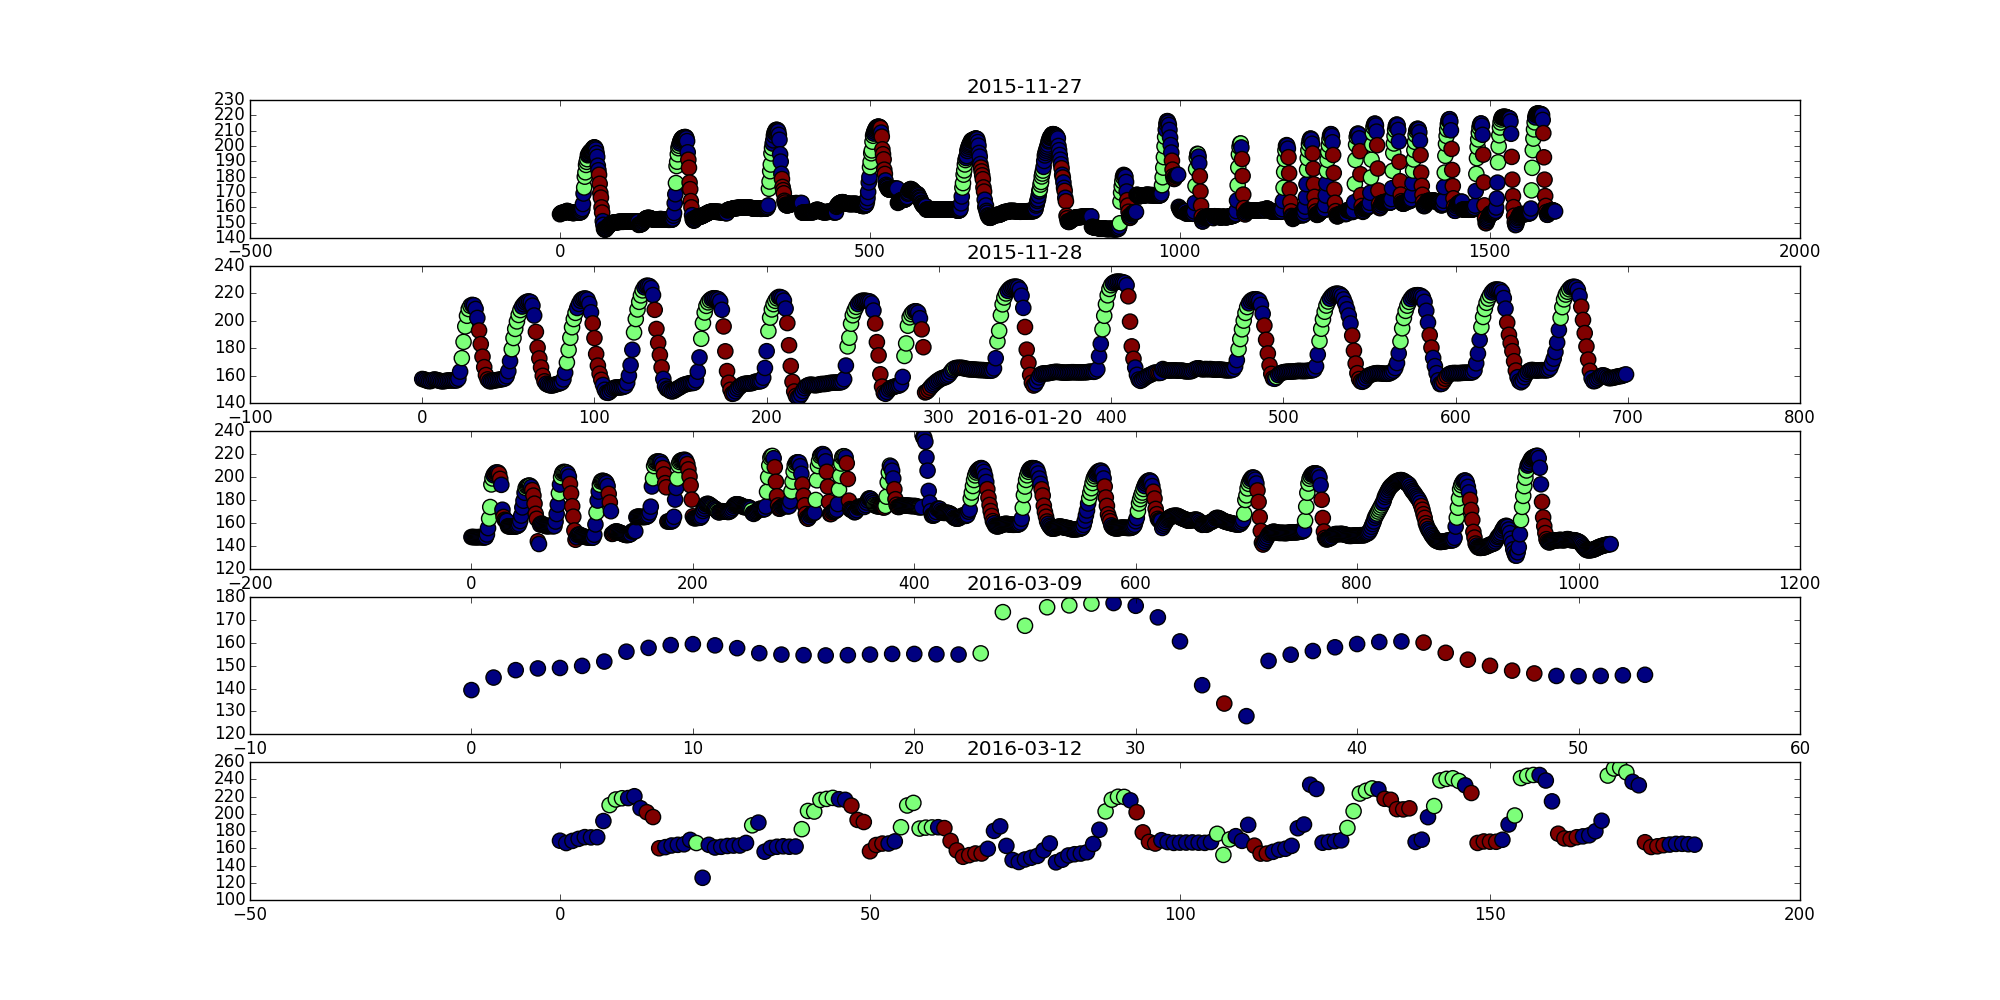

In [4]:
Image(filename='data/merged/look_left-plots.png')


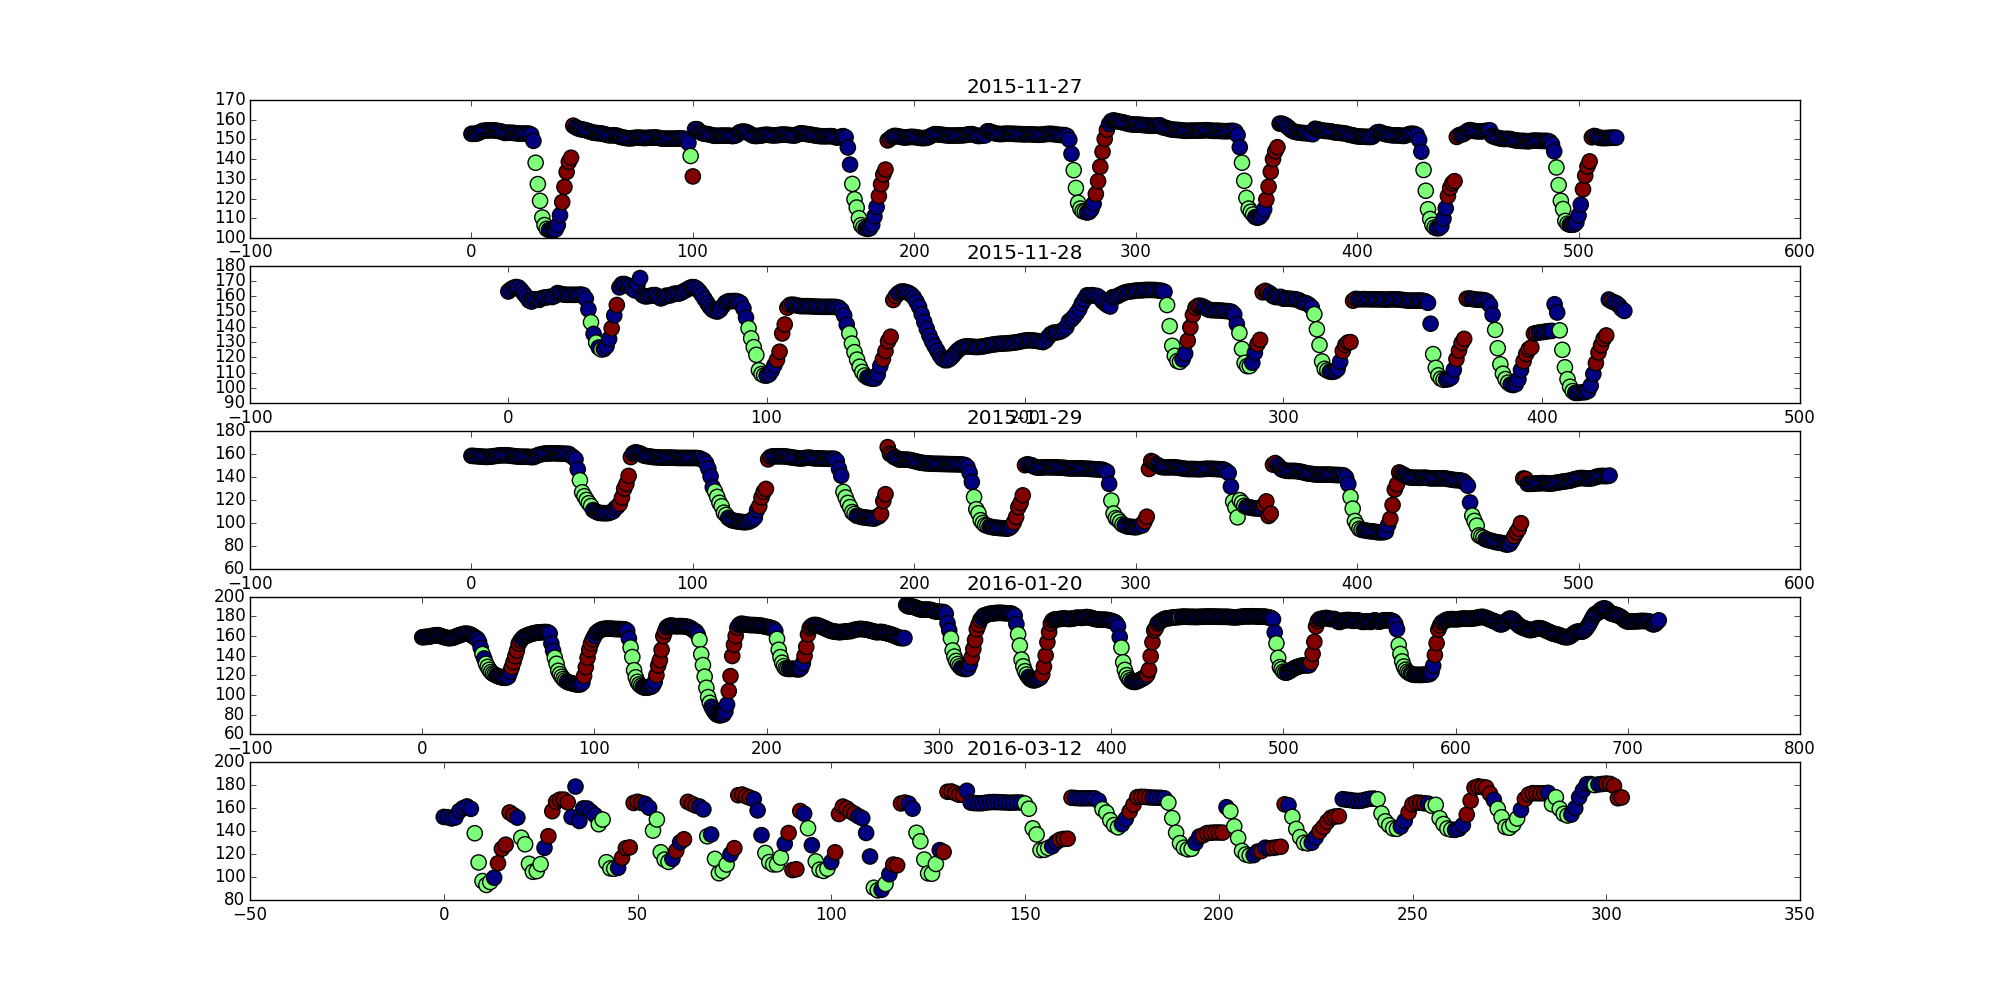

In [5]:
Image(filename='data/merged/look_right-plots.png')

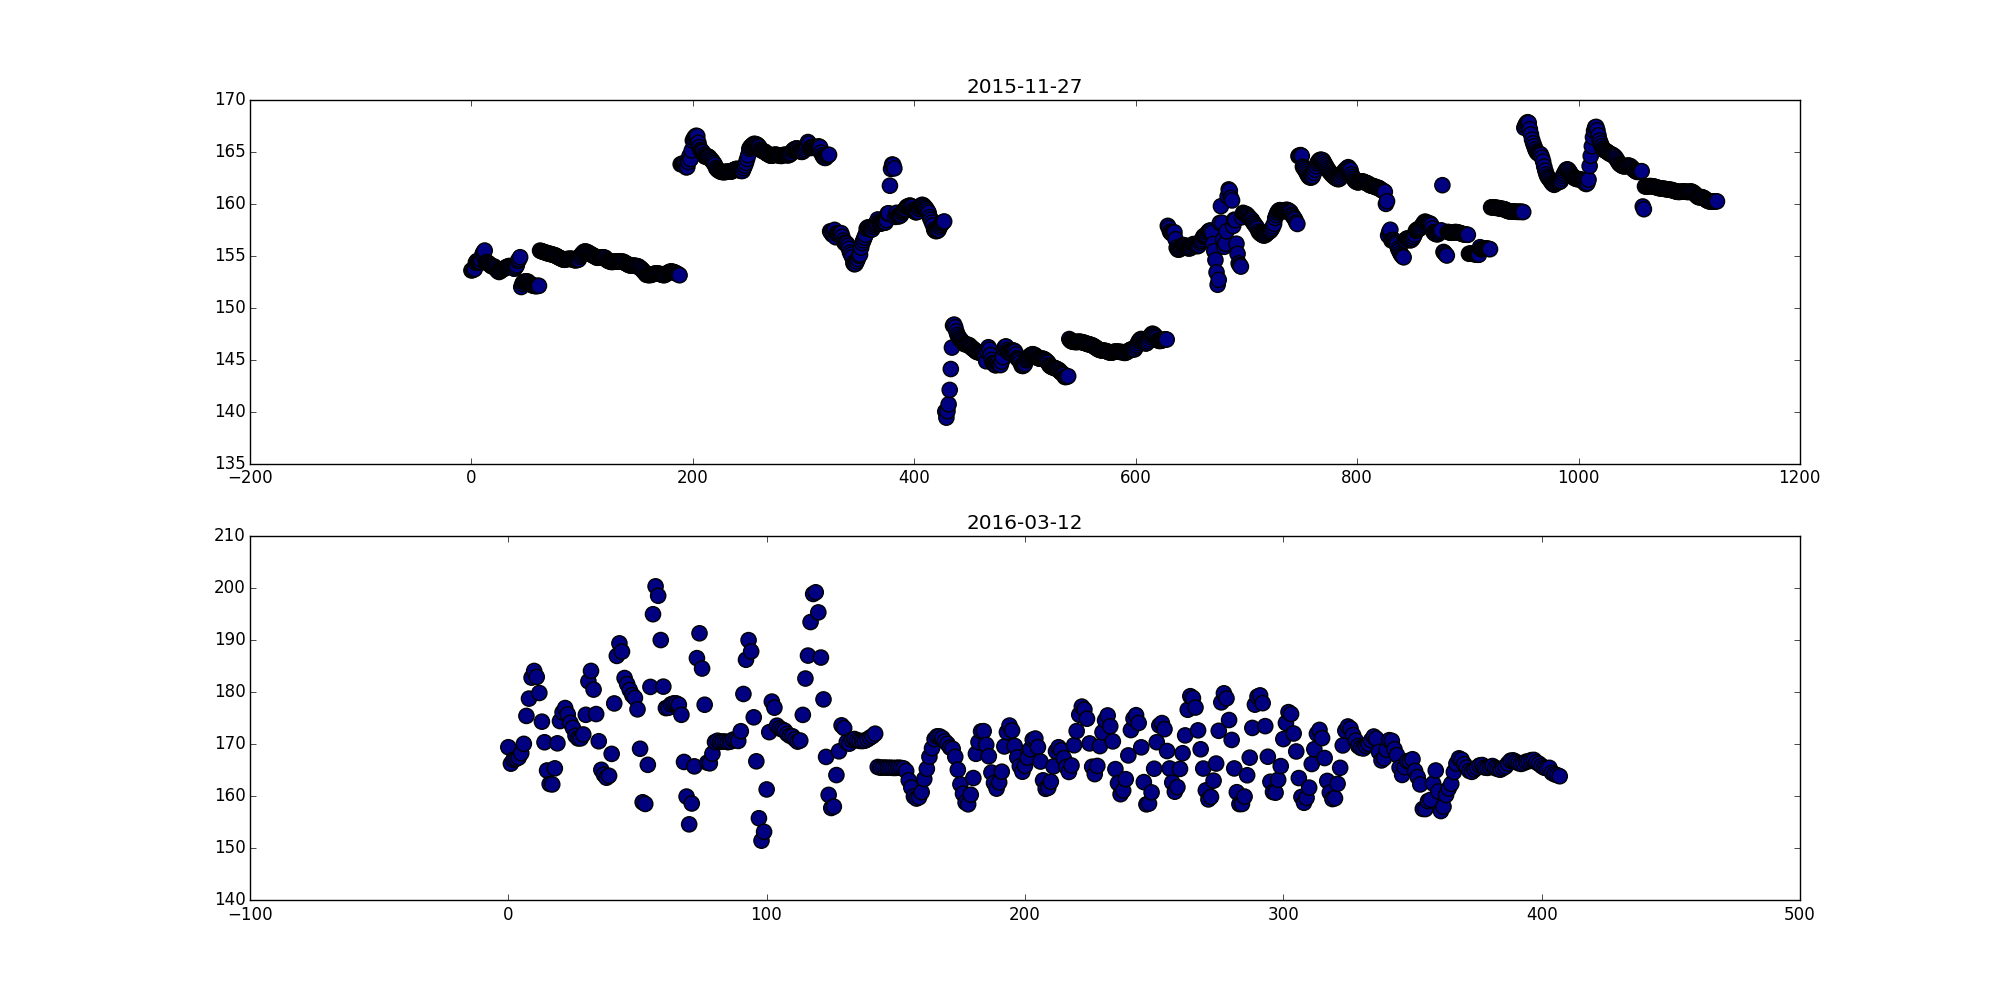

In [6]:
Image(filename='data/merged/look_straight-plots.png')


In [7]:
config = json.loads(open('config.json','r').read())
active_features = config['active_features']

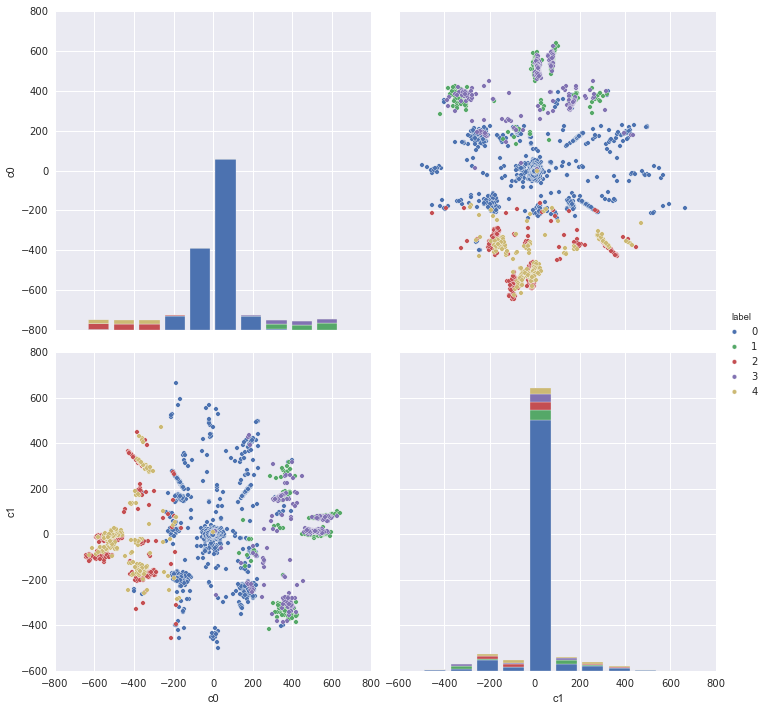

In [48]:
import seaborn as sns
pca = PCA(n_components=2)
X = pca.fit_transform(df[config['active_features']])
# p, = plt.scatter(X[:,0],X[:,1], c=df['class'])

# plt.legend(p, ['0','1','2','3','4'])
df_plot = pd.DataFrame(X)
df_plot["c0"] = df_plot[0]
df_plot["c1"] = df_plot[1]
df_plot['label'] = map(str,list(df['class']))
sns.pairplot(df_plot, hue="label", vars=['c0','c1'], size=5)

In [49]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder


def compute_metrics(X_test, Y_test, Y_pred, label):
    i = label
    id_rated_t = X_test.index[Y_pred == i]
    id_is_t = X_test.index[Y_test == i]
    n = len(X_test)
    truths = set(id_is_t)
    positives = set(id_rated_t)
    tp = len(truths.intersection(positives))
    fp = len(positives.difference(truths.intersection(positives)))
    fn = len(truths.difference(truths.intersection(positives)))
    tn = n - tp - fp - fn


    precision = tp / float(max([1,fp + tp]))
    recall = tp / float(max([1,tp + fn]))
    accuracy = (tp + tn) / float(n)
    return (precision, recall, accuracy)

def train_split_classify(df, active_features, y_feature, clf, k = 4, verbose=False,
                        class_label_append = ''):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    classes = set(Y)
    accuracies = [[]]*len(classes)
    recalls = [[]]*len(classes)
    precisions = [[]]*len(classes)
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        for i in classes:
#             id_rated_t = X_test.index[Y_pred == i]
#             id_is_t = X_test.index[Y_test == i]
#             n = len(X_test)
#             truths = set(id_is_t)
#             positives = set(id_rated_t)
#             tp = len(truths.intersection(positives))
#             fp = len(positives.difference(truths.intersection(positives)))
#             fn = len(truths.difference(truths.intersection(positives)))
#             tn = n - tp - fp - fn


#             precision = tp / float(max([1,fp + tp]))
#             recall = tp / float(max([1,tp + fn]))
#             accuracy = (tp + tn) / float(n)
            precision, recall, accuracy = compute_metrics(X_test, Y_test, Y_pred, i)
            accuracies[i].append(accuracy)
            recalls[i].append(recall)
            precisions[i].append(precision)
            if verbose==True:
                print "Class", i 
                print 'precision', precision
                print 'recall', recall
                print 'accuracy', accuracy
                print '\n======'
    
    metrics = []
    for i in classes:
        metrics.append(dict(
            label=i,
            precision=np.mean(precisions[i]),
            recall=np.mean(recalls[i]),
            accuracy=np.mean(accuracies[i]),
            classifier=str(clf.__class__) + class_label_append,
            ))
    return metrics
#     print 'Confusion Matrix:', sum(cof_mat)
#     print 'Accuracy:', np.mean(accuracies)
#     print 'Recall:', np.mean(recalls)
#     print 'Precision:', np.mean(precisions)

In [50]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


res = []
# svm = SVC()
# res += train_split_classify(df, config['active_features'], 'class',svm)

rf = RandomForestClassifier()
res += train_split_classify(df, config['active_features'], 'class',rf)

gbc = GradientBoostingClassifier()
res += train_split_classify(df, config['active_features'], 'class',gbc)

knn = KNeighborsClassifier(n_neighbors=10)
res += train_split_classify(df, config['active_features'], 'class',knn,  class_label_append='k=10')


knn2 = KNeighborsClassifier(n_neighbors=5)
res += train_split_classify(df, config['active_features'], 'class',knn2, class_label_append='k=5')


# combine results
df_res = pd.DataFrame(res)



Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>


Cross validating for <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


In [ ]:
df_res.groupby('classifier').mean()[['accuracy', 'precision','recall']]

# Testing on Pure Test Data

In [ ]:
df_left_test = pd.read_csv('data/merged/look_left_test.csv')
df_right_test = pd.read_csv('data/merged/look_right_test.csv')

df_straight_test = pd.read_csv('data/merged/look_straight_test.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right_test['class'] = df_right_test['class'].apply(lambda x: x + 2 if x > 0 else 0)
df_test = pd.concat([df_left_test, df_right_test, df_straight_test])


In [ ]:
def compute_test_data(df, df_test, clf):
    Y_test = df_test['class']
    classes = set(Y_test)
    X_test = df_test[active_features]
    clf.fit(df[active_features], df['class'])
    Y_pred = clf.predict(X_test)
    print 'PREDICTING TEST RESULTS FOR ', clf.__class__
    for i in classes:
        print i
        print compute_metrics(X_test, Y_test, Y_pred,i)

In [ ]:
compute_test_data(df, df_test, rf)
compute_test_data(df, df_test, knn)

In [ ]:
Image(filename='data/merged/look_left_test-plots.png')


In [ ]:
Image(filename='data/merged/look_right_test-plots.png')
